# 1. Exploratory Data Analysis (EDA)

We begin by loading and inspecting the Favorita dataset files. This includes sales data (train.csv, test.csv), store metadata, daily oil prices, and holidays/events.
We summarize data structures and generate visualizations to uncover patterns: for example, daily total sales trends, breakdowns by product family and store, seasonal/weekly effects, and the impact of external factors like oil prices and holidays.
According to the dataset documentation, Ecuador's economy is heavily dependent on oil revenues, so oil prices fluctutaions are expected to correlate with retail sales.
We also note key events like public-sector paydays (every 15th and end of month) and the April 16th 2016 earthquake, which are known to have significantly affected sales.

## EDA Tasks:

1. Load and inspect train.csv, test.csv, stores.csv, oil.csv and holidays_events.csv.
2. Check data completeness and basic statistics
3. Plot daily total sales over time to see trends and spikes.
4. Plot sales by product family and sales by store to identify major contributors.
5. Explore seasonility (e.g. by month or weekday) in sales.
6. Examine oil price correlation with sales over time.
7. Analyze holiday/event effects on sales (flagging special days).
8. Mark special dates: paydays (15th and last day of month) and the 2016-04-16 earthquake.

In [1]:
# Load Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read datasets
train = pd.read_csv("train.csv", parse_dates=['date'])
test = pd.read_csv("test.csv", parse_dates=['date'])
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv", parse_dates=['date'])
holidays = pd.read_csv("holidays_events.csv", parse_dates=['date'])

In [3]:
# Quick overview
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Stores shape:", stores.shape)
print("Oil shape:", oil.shape)
print("Holidays shape:", holidays.shape)

Train shape: (3000888, 6)
Test shape: (28512, 5)
Stores shape: (54, 5)
Oil shape: (1218, 2)
Holidays shape: (350, 6)


In [4]:
# Display first few rows to inspect columns
display(train.head())
display(stores.head())
display(oil.head())
display(holidays.head())

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


We then aggregate daily sales by summing all store-family sales on each date. This reveals overall trends and anomalies. We plot the time series of total daily sales, marking paydays and the earthquake date for reference.

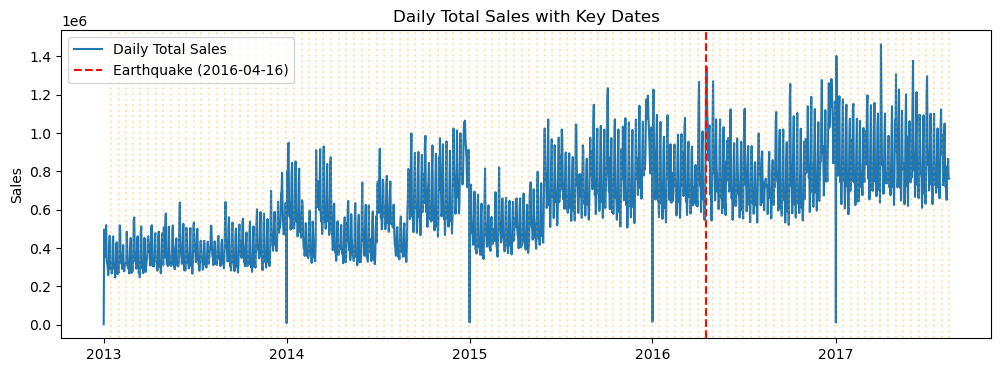

In [5]:
# Aggregate daily total sales
daily_sales = train.groupby('date')['sales'].sum().reset_index()

# Plot daily total sales
plt.figure(figsize=(12,4))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Daily Total Sales')
plt.axvline(pd.Timestamp('2016-04-16'), color='Red', linestyle='--', label='Earthquake (2016-04-16)')

#Mark paydays (15th and month-end for each month in range)
month_starts = pd.date_range(train['date'].min(), train['date'].max(), freq='MS')
for month_start in month_starts:
    fifteenth = month_start + pd.DateOffset(days=14)
    lastday = month_start + pd.offsets.MonthEnd(0)
    if fifteenth <= train['date'].max():
        plt.axvline(fifteenth, color='orange', linestyle=':', alpha=0.3)
    if lastday <= train['date'].max():
       plt.axvline(lastday, color='orange', linestyle=':', alpha=0.3)
plt.title("Daily Total Sales with Key Dates")
plt.ylabel("Sales")
plt.legend()
plt.show()

The above plot helps us see overall trends and how sales spikes around paydays (orange lines) and after the earthquake (red line).
Next we break down sales by product family and by store to identify which families and locations drive the most sales

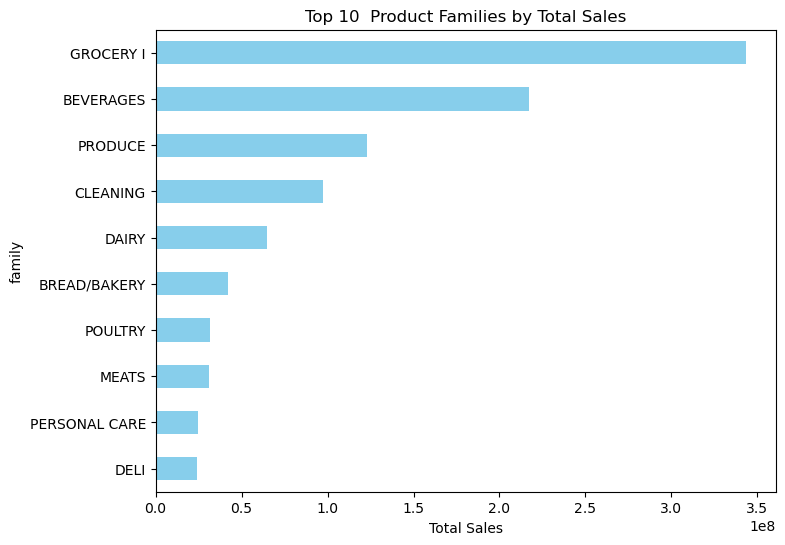

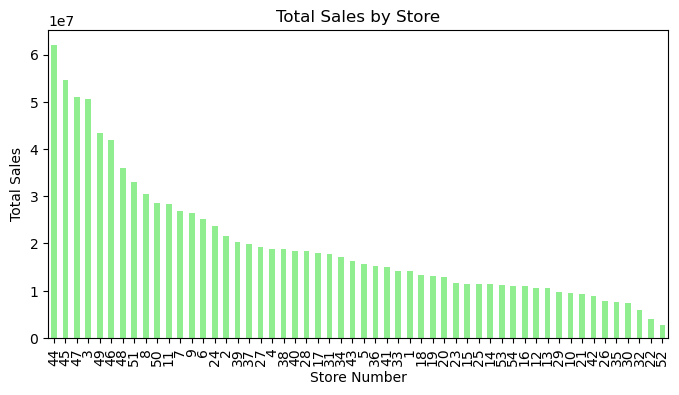

In [6]:
# Top product families by total sales
family_sales = train.groupby('family')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(8,6))
family_sales.head(10).plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Total Sales")
plt.title("Top 10  Product Families by Total Sales")
plt.show()

# Total sales per store
store_sales = train.groupby('store_nbr')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(8,4))
store_sales.plot(kind='bar', color='lightgreen')
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.title("Total Sales by Store")
plt.show()

To explore seasonal patterns, we aggregate by month and day-of-week. For example, we compute average sales by month and plot them to see annual seasonality.
We also check average sales by weekday to see weekday patterns.

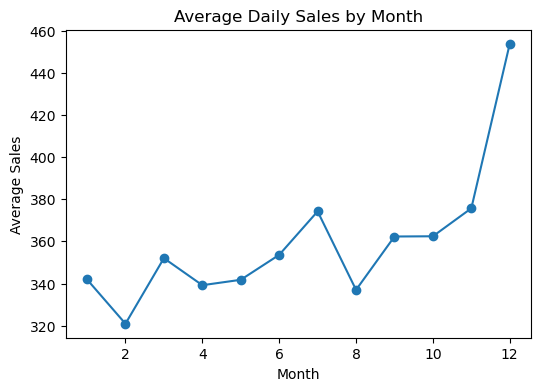

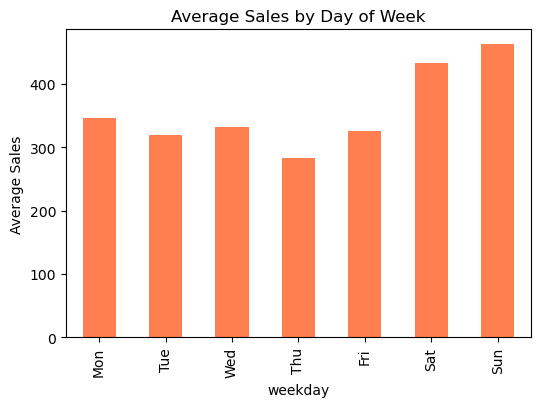

In [7]:
# Monthly average sales (seasonal effect)
train['month'] = train['date'].dt.month
monthly_avg = train.groupby('month')['sales'].mean()
plt.figure(figsize=(6,4))
monthly_avg.plot(kind='line', marker='o')
plt.title("Average Daily Sales by Month")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()

#Weekday (Mon=0 .. Sun=6) average sales
train['weekday'] = train['date'].dt.dayofweek
weekday_avg = train.groupby('weekday')['sales'].mean()
plt.figure(figsize=(6,4))
weekday_avg.plot(kind='bar', color='coral')
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title("Average Sales by Day of Week")
plt.ylabel("Average Sales")
plt.show()

To assess oil price correlation, we merge daily total sales with daily oil price and create a scatter plot.
Since Ecuador's economy is oil-dependent, large swings in oil price might coincide with sales trends.

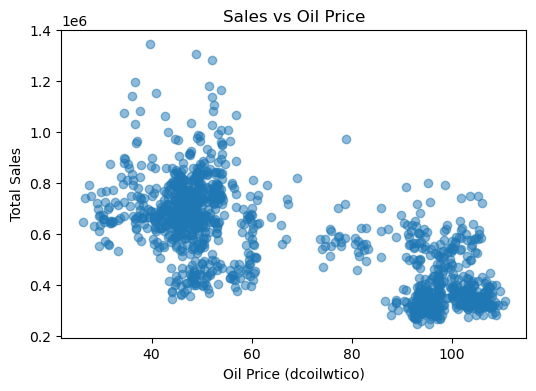

In [8]:
# Merge daily sales with oil price
oil_data = oil.rename(columns={'dcoilwtico': 'oil_price'})
sales_oil = pd.merge(daily_sales, oil_data, on='date', how='left')
plt.figure(figsize=(6,4))
plt.scatter(sales_oil['oil_price'], sales_oil['sales'], alpha=0.5)
plt.title("Sales vs Oil Price")
plt.xlabel("Oil Price (dcoilwtico)")
plt.ylabel("Total Sales")
plt.show()

Finally, we examine holiday/event effects.
We merge the sales data with the holiday_events.csv, which contains flags and types of holidays.
We create a simple indicator of holiday vs normal day and compare sales distributions.
Note: the metadata indicates the "transferred" holidays should be treated carefully (See Feature Engineering below for details)

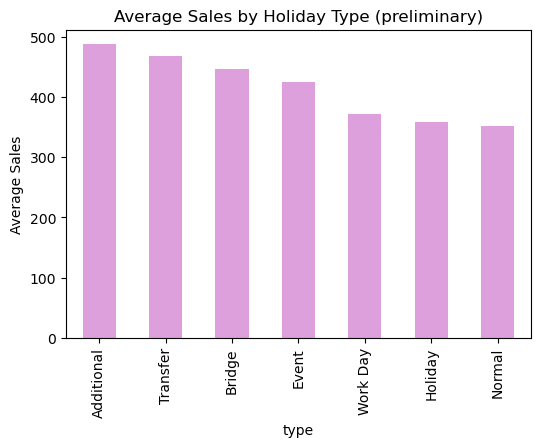

In [9]:
# Mark holiday deals in training data (preliminary, handling detailed logic later)
train = train.merge(holidays[['date','type']], on='date', how='left')
train['type'].fillna('Normal', inplace=True)
holiday_sales = train.groupby('type')['sales'].mean().sort_values(ascending=False)
plt.figure(figsize=(6,4))
holiday_sales.plot(kind='bar', color='plum')
plt.title("Average Sales by Holiday Type (preliminary)")
plt.ylabel("Average Sales")
plt.show()

From these plots and summaries, we see clear patterns: seasonal trends(monthly/weekly), outliers around holidays and the 2016 earthquake, and strong contributions from certain families and stores.
This sets the stage for feature engineering.

## 2. Feature Engineering

We now create features that capture calendar effects, external factors, and lagged sales.
Key steps include:
* a) Calendar Features: Extract day-of-week, month, day-of-month, weekend flag, month-end flag etc. We add a payday flag (public-sector paydays on 15th and last day).
* b) Holiday/events processing: Merge holidays, but drop or adjust "transferred" holidays as per the dataset notes. That is, if a holiday was officially moved, we count the actual observed day (type="Transfer") as holiday, and treat the original date as normal.
* c) Store metadata: Merge store info (city, state, store type, cluster) into the sales records.
* d) Oil prices: Merge daily oil price and fill missing values by forward/backward fill.
* e) Lag and rolling features: For each (store, family) time series, add lag features (e.g. sales 7,14,28 days ago) and rolling means (e.g. past 7/14/28-day average). These lag features capture serial dependence in sales.

In [10]:
# Clean train and test before merging

# if train/test accidentally have a 'type' column, drop it

for df in [train, test]:
    if 'type' in df.columns and 'type' not in stores.columns:
        df.drop(columns=['type'], inplace=True)
# Add sales placeholder to test
test['sales'] = np.nan

# Combine train and test for consistent feature engineering (label missing in test)
df_all = pd.concat([train,test], sort=False).reset_index(drop=True)

# Ensure date is datetime
df_all['date'] = pd.to_datetime(df_all['date'])

# Calendar features
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month
df_all['day'] = df_all['date'].dt.day
df_all['day_of_week'] = df_all['date'].dt.dayofweek
df_all['is_weekend'] = df_all['day_of_week'].isin([5,6]).astype(int)

# Payday flags (15th or last day of month)
df_all['days_in_month']= df_all['date'].dt.days_in_month
df_all['is_month_end']= (df_all['day'] == df_all['days_in_month']).astype(int)
df_all['payday_flag']= ((df_all['day'] == 15) | (df_all['is_month_end'] == 1)).astype(int)

# Holiday/event flags
# Normalize holiday types
holidays['type'] = holidays['type'].str.strip()
# Identify holidays to use: types Holiday and Bridge or Transfer on transfer dates
holidays['transferred'] = holidays['transferred'] == True
# Keep holidays where not transferred, plus any Bridge, plus Transfer type entries
holiday_mask = ((holidays['type'] == 'Holiday') & (~holidays['transferred'])) | (holidays['type'] =='Bridge') | (holidays['type'] == 'Transfer')
holidays_used = holidays[holiday_mask].copy()
holidays_used['holiday_flag'] = 1
holidays_used = holidays_used[['date', 'holiday_flag']]
df_all = df_all.merge(holidays_used, on='date', how='left')
df_all['holiday_flag'] = df_all['holiday_flag'].fillna(0)

# Earthquake flag (several weeks after 2016-04-16)
df_all['eq_flag'] = ((df_all['date'] >= '2016-04-16') & (df_all['date'] <= '2016-05-15')).astype(int)

# Merge store metadata
# stores = stores.set_index('store_nbr')
# for col in ['city', 'state', 'type', 'cluster']:
#     df_all[col] = df_all['store_nbr'].map(stores[col])

df_all = df_all.merge(stores, on='store_nbr', how='left')

# Fix type_x/type_y issues
if 'type_y' in df_all.columns:
    df_all.rename(columns={'type_y': 'type'}, inplace=True)
if 'type_x' in df_all.columns:
    df_all.drop(columns=['type_x'], inplace=True)
    
# Merge oil prices
df_all = df_all.merge(oil.rename(columns={'dcoilwtico':'oil_price'}), on='date', how='left')
df_all['oil_price'].fillna(method='ffill', inplace=True)
df_all['oil_price'].fillna(method='bfill', inplace=True)

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder
le_family = LabelEncoder()
df_all['family_encoded'] = le_family.fit_transform(df_all['family'])
for col in ['city', 'state', 'type']:
    df_all[col] = df_all[col].astype('category').cat.codes

# Create lag features for sales (use groupby by store and family)
df_all = df_all.sort_values(['store_nbr', 'family', 'date'])
for lag in [7,14,28]:
    df_all[f'sales_lag_{lag}'] = df_all.groupby(['store_nbr', 'family'])['sales'].shift(lag)
for window in [7,14,28]:
    df_all[f'sales_roll_mean_{window}'] = (
        df_all
        .groupby(['store_nbr', 'family'])['sales']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
    )
    
# After feature creation, split back into train/test
df_train = df_all[df_all['sales'].notna()].copy()
df_test = df_all[df_all['sales'].isna()].copy()
df_test.drop(columns=['sales'], inplace=True)

In [11]:
# # Testing to see the correct columns merged
# print(train.columns)
# print(test.columns)
# print(stores.columns)
# print(df_all.columns)

The holiday_flag was constructed following the guidance that "transferred" holidays are officially observed on a new date, so we use the row with type "Transfer" as the actual holiday (and do not count the original date).
We also add an eq_flag for the earthquake aftermath (one month after April 16,2016) as it "greatly affected sales for several weeks".

Next, we prepare for modeling by transforming the target. We will predict sales, but we train on log1p(sales) to optimize for RMSLE, which is the competition metric.
The RMSLE (Root Mean Squared Logarithmic Error) is defined as the square root of the average squared difference of log-transformed predictions and truth. In practice we will use NumPy's np.log1p and np.expm1 to apply and invert this transform for training and evaluation.

## 3. Modeling

We implement three types of models:
* 1. An ARIMA/SARIMAX on a single series.
* 2. A Prophet time-series model with holidays
* 3. An XGBoost regression on the engineered features.
We then compare their performances (RMSLE) on a validation set.

* 1. SARIMAX (ARIMA with exogenous variables) - We select a representative series (e.g.a popular store-family pair) and fit a seasonal ARIMA model using statsmodels. This model can capture autoregressive and moving-average components, including seasonal periodicity (we use weekly seasonility here).
* 2. Prophet - We aggregate a series (e.g total sales or a key family) and fit Facebook's Prophet, which models trend, yearly seasonility and custom holiday effects. We supply Ecuador's holiday by using Prophet's built-in country holidays or a custom holidays DataFrame.
* 3. XGBoost - We conver the time series forecasting to a supervised learning problem: our feature matrix contains all engineered features above (including lags), and the target is log-sales. XGBoost is a gradient-boosting tree ensemble that often performs very well on structured data. We split the training data by time (e.g. last 30 days as validation) to avoid lookahead bias.

We train each model and compute RMSLE on the validation period.

In [12]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_log_error

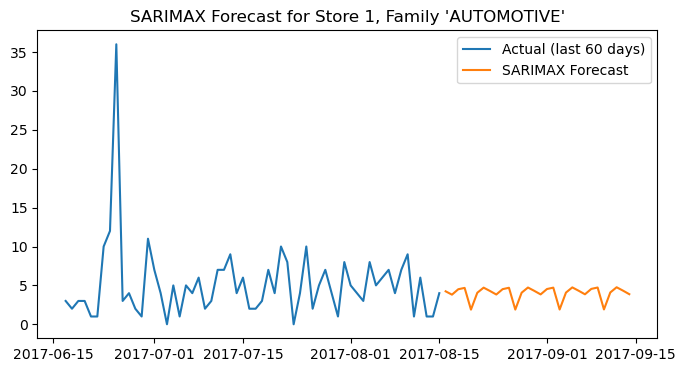

In [13]:
# SARIMAX example

# Pick a single (store_nbr, family) series from train for illustration
mask = (df_train['store_nbr']==1) & (df_train['family']=='AUTOMOTIVE')
# series = df_train[mask].set_index('date')['sales'].asfreq('D').fillna(0)
# Aggregate daily
series = (df_train[mask].groupby('date')['sales'].sum().asfreq('D').fillna(0))
series_log = np.log1p(series)

# Fit SARIMAX with weekly seasonility (period = 7)
sarima = sm.tsa.SARIMAX(series_log, order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_fit = sarima.fit(disp=False)
sarima_forecast_log = sarima_fit.forecast(steps=30)
sarima_forecast = np.expm1(sarima_forecast_log)

# Plot SARIMAX actual vs forecast
plt.figure(figsize=(8,4))
plt.plot(series.index[-60:], series[-60:], label='Actual (last 60 days)')
forecast_index = pd.date_range(series.index[-1]+pd.Timedelta(days=1), periods=30)
plt.plot(forecast_index, sarima_forecast, label='SARIMAX Forecast')
plt.title("SARIMAX Forecast for Store 1, Family 'AUTOMOTIVE'")
plt.legend()
plt.show()

In [14]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [15]:
# !pip install plotly

13:52:13 - cmdstanpy - INFO - Chain [1] start processing
13:52:13 - cmdstanpy - INFO - Chain [1] done processing


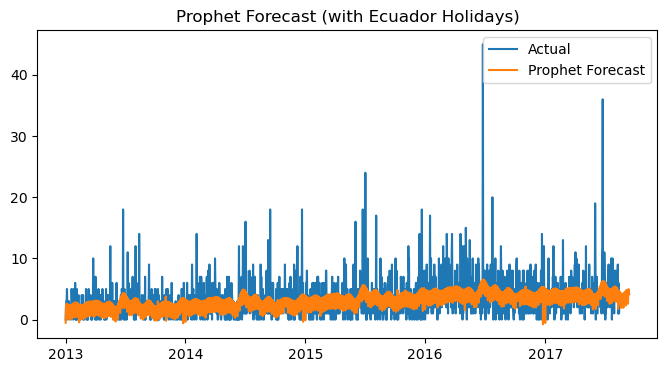

In [16]:
# Prophet example

# Prepare dataframe for Prophet (total daily sales of the same series)
prophet_df = series.reset_index().rename(columns={'date': 'ds', 'sales': 'y'})
# Initialize Prophet and addd country holidays for Ecuador
from prophet import Prophet
m = Prophet(holidays=None, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
# If 'EC' country code is supported:
try:
    m.add_country_holidays(country_name='EC')
except Exception:
    pass
m.fit(prophet_df)

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
plt.figure(figsize=(8,4))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast')
plt.title("Prophet Forecast (with Ecuador Holidays)")
plt.legend()
plt.show()


In [18]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   - -------------------------------------- 5.0/124.9 MB 37.7 MB/s eta 0:00:04
   ---- ----------------------------------- 14.2/124.9 MB 40.5 MB/s eta 0:00:03
   ------- -------------------------------- 22.3/124.9 MB 39.2 MB/s eta 0:00:03
   --------- ------------------------------ 30.9/124.9 MB 40.9 MB/s eta 0:00:03
   ------------ --------------------------- 38.0/124.9 MB 41.0 MB/s eta 0:00:03
   ------------- -------------------------- 41.2/124.9 MB 34.5 MB/s eta 0:00:03
   --------------- ------------------------ 49.8/124.9 MB 35.6 MB/s eta 0:00:03
   ------------------ --------------------- 58.5/124.9 MB 36.2 MB/s eta 0:00:02
   --------------------- ------------------ 68.2/124.9 MB 37.5 MB/s eta 0:00:02
   ------------------------ --------------- 77.3/124.9 MB 37.9 MB/s eta 0:00:02
   --------------------------- ------------ 86.2/124.9 MB 38.5 MB/s eta 0:00:02
   ------------------------------ --------- 95.7/1

In [24]:
# XGBoost on all data

import xgboost as xgb

# Feature columns to use
feature_cols = [
    'store_nbr', 'family_encoded', 'city', 'state', 'type', 'cluster',
    'onpromotion', 'oil_price', 'day_of_week', 'month', 'is_month_end',
    'is_weekend', 'holiday_flag', 'eq_flag'
] + [f'sales_lag_{lag}' for lag in [7,14,28]] \
  + [f'sales_roll_mean_{w}' for w in [7,14,28]]

# Prepare train/validation split by date
max_date = df_train['date'].max()
val_split = max_date - pd.Timedelta(days=30)
train_x = df_train[df_train['date'] < val_split]
val_x = df_train[df_train['date'] >= val_split]
X_train = train_x[feature_cols]
y_train = np.log1p(train_x['sales'])
X_val = val_x[feature_cols]
y_val = np.log1p(val_x['sales'])

# DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'learning_rate':0.1, 'max_depth':8}
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_model = xgb.train(params, dtrain, num_boost_round=200, evals=watchlist, early_stopping_rounds=20, verbose_eval=False)

# Predict and compute RMSLE on validation set
y_pred_val_log = xgb_model.predict(dval)
y_pred_val = np.expm1(y_pred_val_log)
# rmsle_xgb = np.sqrt(mean_squared_log_error(val_x['sales'], y_pred_val))
y_true = val_x['sales'].clip(lower=0)
y_pred = np.maximum(y_pred_val, 0)
rmsle_xgb = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"XGBoost Validation RMSLE: {rmsle_xgb:.4f}")

XGBoost Validation RMSLE: 0.3883


In [27]:
# XGBoost Inference on Test Data

# Keep the same feature cols and in the same order as training
feature_cols = [
    'store_nbr', 'family_encoded', 'city', 'state', 'type', 'cluster',
    'onpromotion', 'oil_price', 'day_of_week', 'month', 'is_month_end',
    'is_weekend', 'holiday_flag', 'eq_flag'
] + [f'sales_lag_{lag}' for lag in [7,14,28]] \
  + [f'sales_roll_mean_{w}' for w in [7,14,28]]

# Prepare test data
X_test = df_test[feature_cols]
dtest = xgb.DMatrix(X_test)

# Predict log-scale sales
test_pred_log = xgb_model.predict(dtest)

# Convert to original scale
test_pred = np.expm1(test_pred_log)

# Avoid negatives
test_pred = np.maximum(test_pred, 0)

# Attach predictions
df_test['sales_pred'] = test_pred

# Create submission file
submission = df_test[['id', 'sales_pred']].rename(columns={'sales_pred': 'sales'})

# Preview
display(submission.head())

# Save CSV
submission.to_csv("xgboost_submission.csv", index=False)

,id,sales
3132756,3000888,4.701033
3134538,3002670,3.465611
3136320,3004452,3.392368
3138102,3006234,4.793465
3139884,3008016,1.174272


In [28]:
df_test['sales_pred'].describe()

count    28512.000000
mean       198.421661
std        820.887085
min          0.000000
25%          0.138585
50%          5.544265
75%         33.657775
max      14899.185547
Name: sales_pred, dtype: float64

<Axes: xlabel='date'>

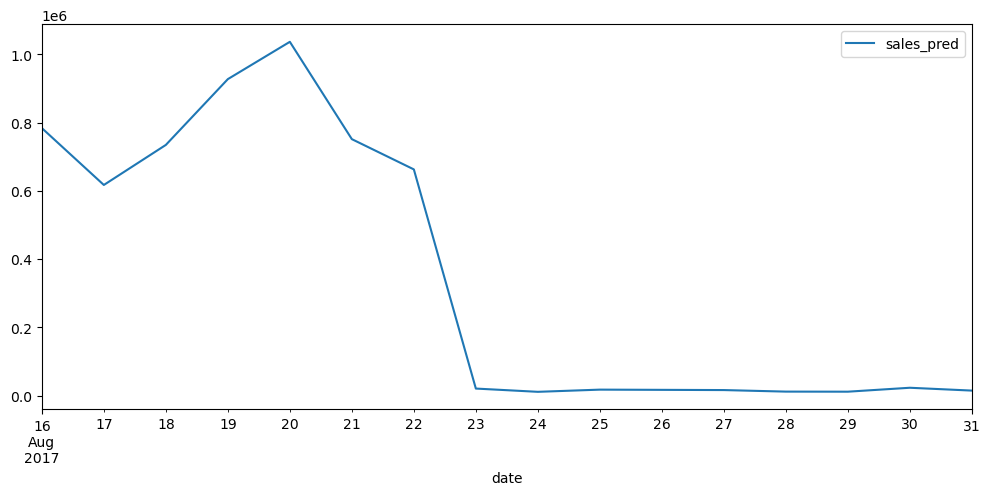

In [29]:
df_test[['date','sales_pred']].groupby('date').sum().plot(figsize=(12,5))